# Uses ROMS Surface variables for Spectral Analysis
#### Computes SST'xHFX' and regression coefficient

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec

def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og



In [4]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [5]:
dxx=0.5
dyy=dxx

In [21]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([1,2,3,4,5,6,7])
mes_str=['Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Spectral Analysis

#### Test - SST and Heatflux

In [7]:
chunks_new={'dayofyear':40}

In [8]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'




In [9]:
%%time


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
# tf=tf[:,120:-120,120:800].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
# tt=tt[:,120:-120,120:800].compute();


hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
# hf=hf[:,120:-120,120:800].compute();

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
# ht=ht[:,120:-120,120:800].compute();


CPU times: user 1.19 s, sys: 7.78 ms, total: 1.2 s
Wall time: 1.19 s


In [138]:
# mask=np.zeros(tf.nav_lon_rho.shape)*np.nan
# up_mask=mask.copy()
# up_mask[120:-800,120:800]=1
# down_mask=mask.copy()
# down_mask[800:-120,120:800]=1


up_mask_x=np.arange(120,800,1)
up_mask_y=np.arange(120,720,1)

down_mask_x=np.arange(120,800,1)
down_mask_y=np.arange(800,1400,1)

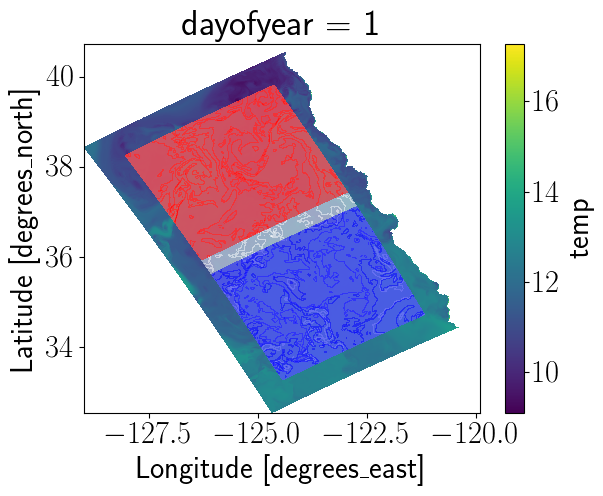

In [140]:
tf[0].plot(x='nav_lon_rho',y='nav_lat_rho');
plt.contourf(tf.nav_lon_rho[120:-120,120:800],tf.nav_lat_rho[120:-120,120:800],tf[0,120:-120,120:800],colors='w',alpha=0.5)

# plt.contourf(tf.nav_lon_rho[120:-800,120:800],tf.nav_lat_rho[120:-800,120:800],tf[120:-800,120:800],colors='r',alpha=0.5)
# plt.contourf(tf.nav_lon_rho[800:-120,120:800],tf.nav_lat_rho[800:-120,120:800],tf[800:-120,120:800],colors='b',alpha=0.5)

# plt.contourf(tf.nav_lon_rho[down_mask],tf.nav_lat_rho[down_mask],tf[0][down_mask],colors='r',alpha=0.5)
# plt.contourf(tf.nav_lon_rho[up_mask],tf.nav_lat_rho[up_mask],tf[0][up_mask],colors='b',alpha=0.5)

plt.contourf(tf.nav_lon_rho[down_mask_y,down_mask_x],tf.nav_lat_rho[down_mask_y,down_mask_x],tf[0][down_mask_y,down_mask_x],colors='r',alpha=0.5)
plt.contourf(tf.nav_lon_rho[up_mask_y,up_mask_x],tf.nav_lat_rho[up_mask_y,up_mask_x],tf[0][up_mask_y,up_mask_x],colors='b',alpha=0.5)

In [10]:
sf=varf.salt.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
# sf=sf[:,120:-120,120:800].compute();

st=vart.salt.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
# st=st[:,120:-120,120:800].compute();

In [11]:
%%time
wf=varf.w.groupby("time_counter.dayofyear").mean()
wf=wf.chunk(chunks=chunks_new);
# wf=wf[:,120:-120,120:800].compute();

wt=vart.w.groupby("time_counter.dayofyear").mean()
wt=wt.chunk(chunks=chunks_new);
# wt=wt[:,120:-120,120:800].compute();



CPU times: user 564 ms, sys: 10.5 ms, total: 575 ms
Wall time: 569 ms


In [12]:
import xroms 

rhof=xroms.potential_density(tf,sf)
rhot=xroms.potential_density(tt,st)

In [13]:
bf=xroms.buoyancy(rhof)#[:,1:-1,:]
bt=xroms.buoyancy(rhot)#[:,1:-1,:]

In [145]:
%%time
with ProgressBar():
    Bf_up=xrft.isotropic_power_spectrum(bf[:,up_mask_y,up_mask_x].drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    

    Bt_up=xrft.isotropic_power_spectrum(bt[:,up_mask_y,up_mask_x].drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    
    Bf_down=xrft.isotropic_power_spectrum(bf[:,down_mask_y,down_mask_x].drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)


    Bt_down=xrft.isotropic_power_spectrum(bt[:,down_mask_y,down_mask_x].drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

[########################################] | 100% Completed | 58.2s
[########################################] | 100% Completed | 17.5s
[########################################] | 100% Completed | 58.1s
[########################################] | 100% Completed | 17.6s
CPU times: user 12min 54s, sys: 21min 46s, total: 34min 41s
Wall time: 2min 32s


In [17]:
# %%time
# with ProgressBar():
#     Wf=xrft.isotropic_power_spectrum(wf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
#                                       dim=['y_rho','x_rho'],
#                               nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
#                                      window=wdws,window_correction=wdw_cor)

#     Wt=xrft.isotropic_power_spectrum(wt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
#                                       dim=['y_rho','x_rho'],
#                               nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
#                                      window=wdws,window_correction=wdw_cor)
    
#     Wf=xrft.isotropic_power_spectrum(wf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
#                                       dim=['y_rho','x_rho'],
#                               nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
#                                      window=wdws,window_correction=wdw_cor)

#     Wt=xrft.isotropic_power_spectrum(wt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
#                                       dim=['y_rho','x_rho'],
#                               nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
#                                      window=wdws,window_correction=wdw_cor)

CPU times: user 13min 13s, sys: 40min 35s, total: 53min 48s
Wall time: 1min 11s


In [147]:
N2r=(5.2*10**-3)**2

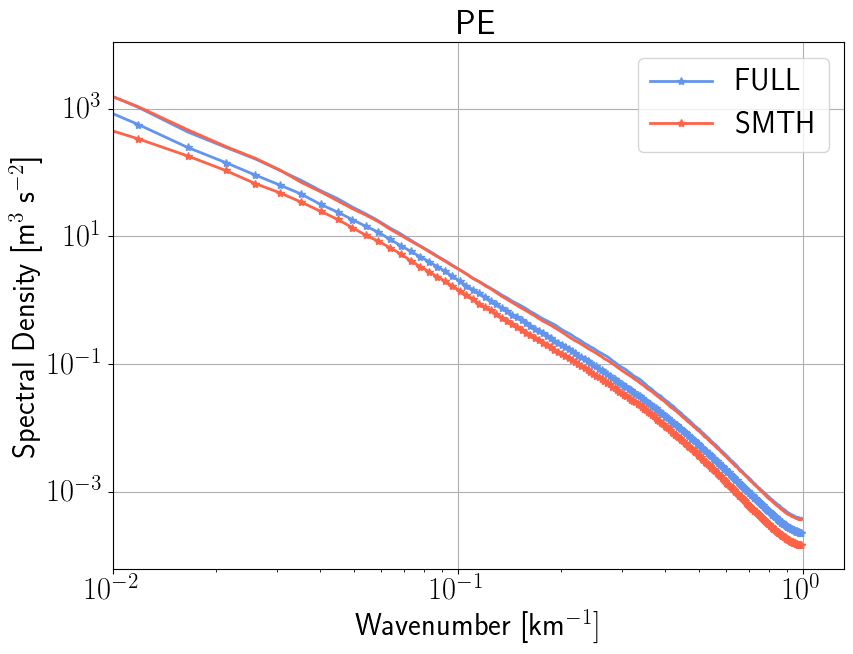

In [167]:
plt.figure(figsize=(9,7))


plt.plot(Bf_up.freq_r/dxx,(1/(2*N2r))*Bf_up.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,marker='*',color='cornflowerblue') #correcting for m in kr
plt.plot(Bt_up.freq_r/dxx,(1/(2*N2r))*Bt_up.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,marker='*',color='tomato')
plt.plot(Bf_down.freq_r/dxx,(1/(2*N2r))*Bf_down.mean(axis=0)/dxx*1e3,linewidth=2,color='cornflowerblue') #correcting for m in kr
plt.plot(Bt_down.freq_r/dxx,(1/(2*N2r))*Bt_down.mean(axis=0)/dxx*1e3,linewidth=2,color='tomato')




# k2 = np.array([Bf.freq_r[0],Bf.freq_r[-1]])/dxx
# E2 = ((1/k2)**2)*(1e-2)

# k3 = np.array([Bf.freq_r[0],Bf.freq_r[-1]])/dxx
# E3 = ((1/k3)**3)*(1e-2)




# plt.plot(k2,E2,'k--',alpha=0.2)
# plt.text(0.7,0.5e-2,r'$\kappa^{-2}$',weight='normal',alpha=0.2)

# plt.plot(k3,E3,'b--',alpha=0.2)
# plt.text(0.7,5e-2,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.2)



plt.legend()

plt.yscale('log')
plt.xscale('log')

# plt.title(r'$\frac{1}{2}\,\frac{b^{2}}{N_r^{2}}$',fontweight='bold')
plt.title(r'PE',fontweight='bold',fontsize=25)


plt.ylabel(r'Spectral Density [m$^3$ s$^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}]$',fontweight='bold')


plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/TWO_REG_Total_avg_surface_PE.png')

# KE 

In [14]:
%time
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.82 µs


In [15]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
# uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
# ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [158]:
with ProgressBar():
    Uf_up=xrft.isotropic_power_spectrum(uf[:,up_mask_y,up_mask_x],dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf_up=xrft.isotropic_power_spectrum(vf[:,up_mask_y,up_mask_x],dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut_up=xrft.isotropic_power_spectrum(ut[:,up_mask_y,up_mask_x],dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt_up=xrft.isotropic_power_spectrum(vt[:,up_mask_y,up_mask_x],dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)       
    
    Uf_down=xrft.isotropic_power_spectrum(uf[:,down_mask_y,down_mask_x],dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf_down=xrft.isotropic_power_spectrum(vf[:,down_mask_y,down_mask_x],dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut_down=xrft.isotropic_power_spectrum(ut[:,down_mask_y,down_mask_x],dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt_down=xrft.isotropic_power_spectrum(vt[:,down_mask_y,down_mask_x],dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [159]:
Ekef_up=xr.DataArray(data=0.5*(Uf_up.data + Vf_up.data),coords=({'dayofyear':Uf_up.dayofyear,'freq_r':Uf_up.freq_r.data}))
Eket_up=xr.DataArray(data=0.5*(Ut_up.data + Vt_up.data),coords=({'dayofyear':Uf_up.dayofyear,'freq_r':Uf_up.freq_r.data}))


Ekef_down=xr.DataArray(data=0.5*(Uf_down.data + Vf_down.data),coords=({'dayofyear':Uf_down.dayofyear,'freq_r':Uf_down.freq_r.data}))
Eket_down=xr.DataArray(data=0.5*(Ut_down.data + Vt_down.data),coords=({'dayofyear':Uf_down.dayofyear,'freq_r':Uf_down.freq_r.data}))

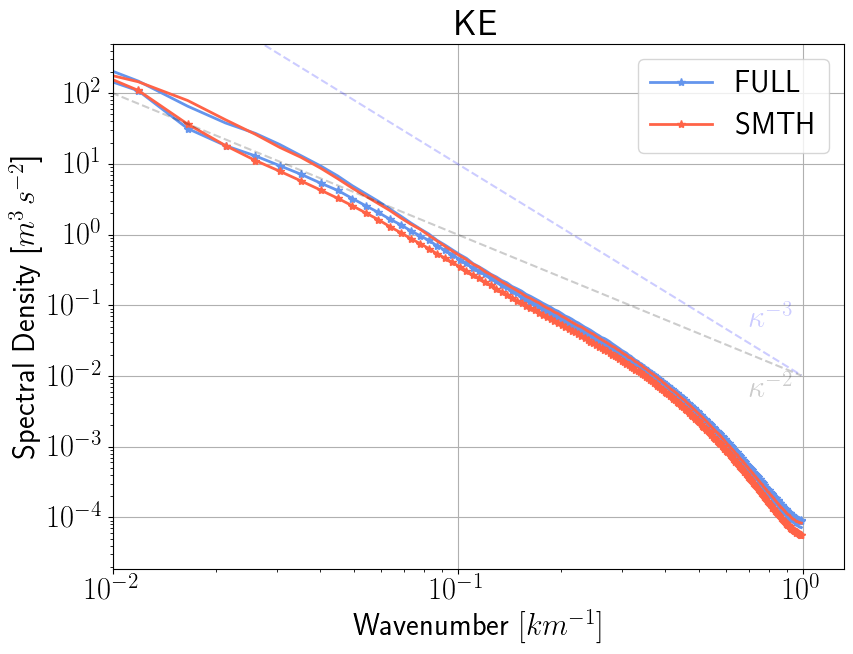

In [166]:
plt.figure(figsize=(9,7))


plt.plot(Ekef_up.freq_r/dxx,Ekef_up.mean(axis=0)*(dxx*1e3),label='FULL',marker='*',linewidth=2,color='cornflowerblue')
plt.plot(Eket_up.freq_r/dxx,Eket_up.mean(axis=0)*(dxx*1e3),label='SMTH',marker='*',linewidth=2,color='tomato')



plt.plot(Ekef_down.freq_r/dxx,Ekef_down.mean(axis=0)*(dxx*1e3),linewidth=2,color='cornflowerblue')
plt.plot(Eket_down.freq_r/dxx,Eket_down.mean(axis=0)*(dxx*1e3),linewidth=2,color='tomato')



k2 = np.array([Ekef_up.freq_r[0],Ekef_up.freq_r[-1]])/dxx
E2 = ((1/k2)**2)*(1e-2)

k3 = np.array([Ekef_up.freq_r[0],Ekef_up.freq_r[-1]])/dxx
E3 = ((1/k3)**3)*(1e-2)


plt.plot(k2,E2,'k--',alpha=0.2)
plt.text(0.7,0.5e-2,r'$\kappa^{-2}$',weight='normal',alpha=0.2)

plt.plot(k3,E3,'b--',alpha=0.2)
plt.text(0.7,5e-2,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.2)

plt.grid()


plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.title('KE',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')

plt.xlim(1e-2,0)
plt.ylim(0,500)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/TWOREG_Total_avg_SURFACE_KE.png')

# Windwork

In [16]:
#loading stress
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
# usf=usf[:,300:-300,90:700].compute();
usf=usf.compute();



ust=vart.sustr.groupby("time_counter.dayofyear").mean()
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();
# ust=ust[:,300:-300,90:700].compute();



vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();
# vsf=vsf[:,300:-300,90:700].compute();


vst=vart.svstr.groupby("time_counter.dayofyear").mean()
vst=vst.chunk(chunks=chunks_new);
# vst=vst[:,300:-300,90:700].compute();
vst=vst.compute();



In [17]:
usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,ust)

# usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
# ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [199]:
uf[:,up_mask_y,up_mask_x]

<xarray.DataArray 'u' (dayofyear: 214, y_u: 600, x_u: 680)>
array([[[-0.05912399, -0.05607774, -0.05379352, ..., -0.02541909,
         -0.02656903, -0.02834895],
        [-0.06770384, -0.06623137, -0.06520496, ..., -0.02545604,
         -0.02866186, -0.03160731],
        [-0.07668877, -0.07357667, -0.07272887, ..., -0.03238314,
         -0.03533424, -0.03647202],
        ...,
        [ 0.08485433,  0.09150955,  0.09594973, ...,  0.01519624,
          0.01184683,  0.00724255],
        [ 0.07594685,  0.08433529,  0.09156843, ...,  0.00256798,
          0.00040292, -0.00695698],
        [ 0.06992894,  0.07737746,  0.08614377, ..., -0.01027351,
         -0.01200157, -0.01994249]],

       [[-0.06752361, -0.07262839, -0.06937724, ..., -0.05338253,
         -0.04827259, -0.0450995 ],
        [-0.07022441, -0.07296704, -0.0709916 , ..., -0.05124607,
         -0.04832134, -0.04806858],
        [-0.08318017, -0.0827075 , -0.07385711, ..., -0.04804965,
         -0.0468784 , -0.0472023 ],
...
        [-0.19822018, -0.19274518, -0.18812507, ..., -0.13680407,
         -0.13528162, -0.13319519],
        [-0.20519722, -0.1994732 , -0.19337831, ..., -0.138482  ,
         -0.13745315, -0.13476713],
        [-0.2102051 , -0.20593789, -0.19987023, ..., -0.13945577,
         -0.13734461, -0.13395189]],

       [[-0.12521249, -0.13440089, -0.14099015, ...,  0.04759159,
          0.04921035,  0.04913493],
        [-0.12455947, -0.13403817, -0.14090334, ...,  0.0494625 ,
          0.05437245,  0.05733676],
        [-0.12310146, -0.13307248, -0.139896  , ...,  0.03988776,
          0.04727984,  0.05320223],
        ...,
        [-0.28702638, -0.27361348, -0.25809696, ..., -0.1484137 ,
         -0.1538253 , -0.15538234],
        [-0.2957203 , -0.2855381 , -0.26956698, ..., -0.14748448,
         -0.15023889, -0.15447964],
        [-0.2990674 , -0.29502863, -0.2834573 , ..., -0.13672453,
         -0.13451694, -0.14269327]]], dtype=float32)
Coordinates:
    nav_lat_u  (y_u, x_u) float32 33.28 33.28 33.28 33.28 ... 37.11 37.12 37.12
    nav_lon_u  (y_u, x_u) float32 -124.4 -124.4 -124.4 ... -122.7 -122.7 -122.7
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214
Dimensions without coordinates: y_u, x_u
Attributes:
    long_name:           u-momentum component
    units:               meter second-1
    online_operation:    instant
    interval_operation:  6 h
    interval_write:      6 h
    cell_methods:        time: point s_rho: mean

In [200]:
nfw=2
with ProgressBar():
    Xf_up=xrft.isotropic_cross_spectrum(usf[:,up_mask_y,up_mask_x],uf[:,up_mask_y,up_mask_x].drop(['nav_lat_u', 'nav_lon_u']),
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yf_up=xrft.isotropic_cross_spectrum(vsf[:,up_mask_y,up_mask_x],vf[:,up_mask_y,up_mask_x].drop(['nav_lat_v', 'nav_lon_v']),
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real


    Xt_up=xrft.isotropic_cross_spectrum(ust[:,up_mask_y,up_mask_x],ut[:,up_mask_y,up_mask_x].drop(['nav_lat_u', 'nav_lon_u']),
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yt_up=xrft.isotropic_cross_spectrum(vst[:,up_mask_y,up_mask_x],vt[:,up_mask_y,up_mask_x].drop(['nav_lat_v', 'nav_lon_v']),
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real


    
    
    
    Xf_down=xrft.isotropic_cross_spectrum(usf[:,down_mask_y,down_mask_x],uf[:,down_mask_y,down_mask_x].drop(['nav_lat_u', 'nav_lon_u']),
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yf_down=xrft.isotropic_cross_spectrum(vsf[:,down_mask_y,down_mask_x],vf[:,down_mask_y,down_mask_x].drop(['nav_lat_v', 'nav_lon_v']),
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real


    Xt_down=xrft.isotropic_cross_spectrum(ust[:,down_mask_y,down_mask_x],ut[:,down_mask_y,down_mask_x].drop(['nav_lat_u', 'nav_lon_u']),
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yt_down=xrft.isotropic_cross_spectrum(vst[:,down_mask_y,down_mask_x],vt[:,down_mask_y,down_mask_x].drop(['nav_lat_v', 'nav_lon_v']),
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real



In [203]:


WWf_up=xr.DataArray(data=(1/1024)*(Xf_up.real.data + Yf_up.real.data),coords=({'dayofyear':Xf_up.dayofyear,'freq_r':Xf_up.freq_r.data}));
WWt_up=xr.DataArray(data=(1/1024)*(Xt_up.real.data + Yt_up.real.data),coords=({'dayofyear':Xt_up.dayofyear,'freq_r':Xt_up.freq_r.data}));


WWf_down=xr.DataArray(data=(1/1024)*(Xf_down.real.data + Yf_down.real.data),coords=({'dayofyear':Xf_down.dayofyear,'freq_r':Xf_down.freq_r.data}));
WWt_down=xr.DataArray(data=(1/1024)*(Xt_down.real.data + Yt_down.real.data),coords=({'dayofyear':Xf_down.dayofyear,'freq_r':Xf_down.freq_r.data}));

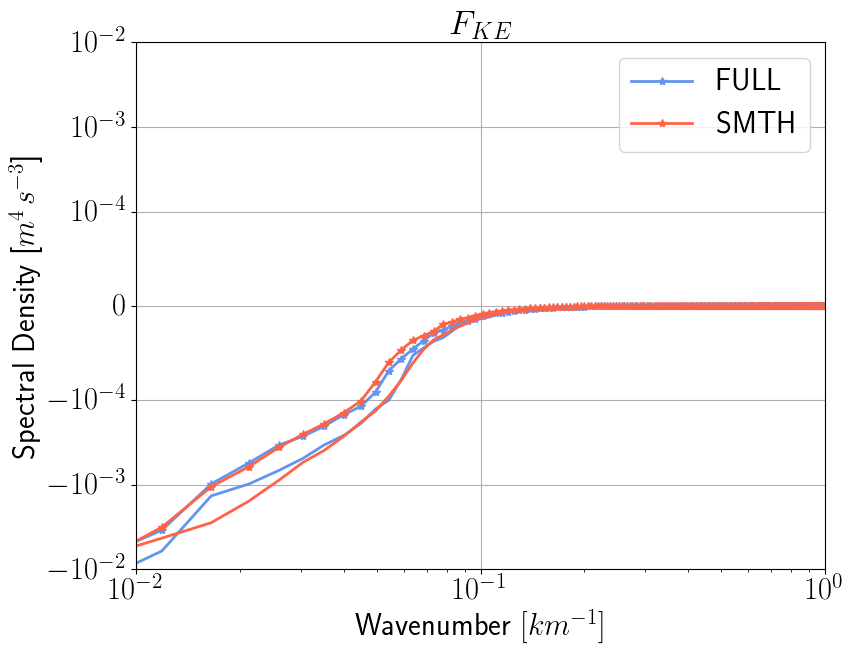

In [205]:

plt.figure(figsize=(9,7))


plt.plot((WWf_up.freq_r/dxx),(np.nanmean(WWf_up,axis=0))*(dxx*1e3),marker='*',label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((WWt_up.freq_r/dxx),(np.nanmean(WWt_up,axis=0))*(dxx*1e3),marker='*',label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.plot((WWf_down.freq_r/dxx),(np.nanmean(WWf_down,axis=0))*(dxx*1e3),linewidth=2,color='cornflowerblue')
plt.plot((WWt_down.freq_r/dxx),(np.nanmean(WWt_down,axis=0))*(dxx*1e3),linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^4\,s^{-3}$]',fontweight='bold')

plt.title(r'$F_{KE}$',fontsize=25,fontweight='bold')
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

plt.ylim(-1e-2,1e-2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/TWOREG_Total_avg_Windwork_KE.png')


# Monthly Analysis 

### b Spectrum

In [40]:
%%time
with ProgressBar():
    Bf=xrft.isotropic_power_spectrum(bf[:,120:-120,120:800].drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    

    Bt=xrft.isotropic_power_spectrum(bt[:,120:-120,120:800].drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

[########################################] | 100% Completed | 21.6s
[########################################] | 100% Completed | 20.8s
CPU times: user 9min 12s, sys: 19min 18s, total: 28min 31s
Wall time: 42.8 s


In [41]:
Bf

<xarray.DataArray (dayofyear: 214, freq_r: 240)>
dask.array<getitem, shape=(214, 240), dtype=float64, chunksize=(40, 240), chunktype=numpy.ndarray>
Coordinates:
  * freq_r   (freq_r) float64 0.001299 0.003082 0.005211 ... 0.4939 0.496 0.4981
Dimensions without coordinates: dayofyear

In [70]:
N2r=(5.2*10**-3)**2
Pef=(1/(2*N2r))*Bf.compute()
Pet=(1/(2*N2r))*Bt.compute()



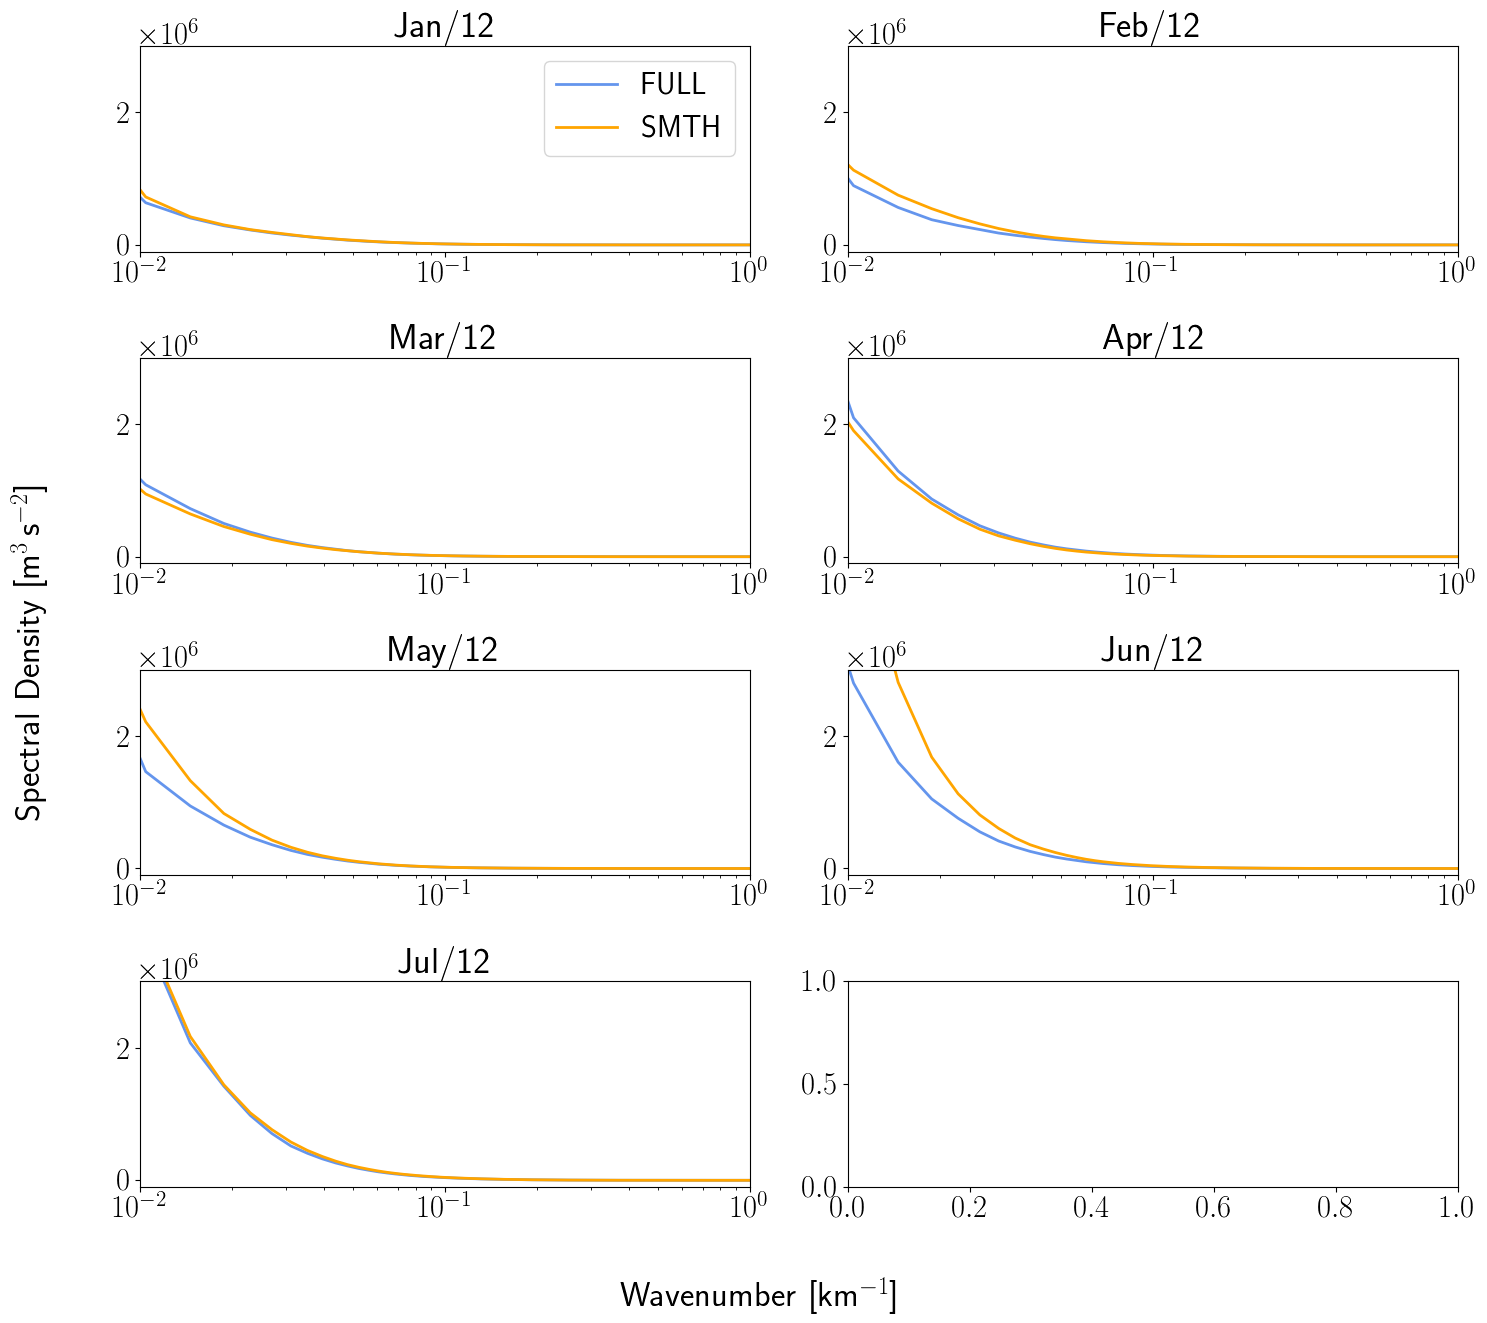

In [72]:

fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    Kbf=ogive(Bf.freq_r/dxx*1e3,np.nanmean(Pef[mon_ind==mes[ipp],:],axis=0)/dxx*1e3) #in metersss
    Kx=Bf.freq_r/dxx #in Kilometers
    Kbt=ogive(Bt.freq_r/dxx*1e3,np.nanmean(Pet[mon_ind==mes[ipp],:],axis=0)/dxx*1e3)#in metersss

    axs[ipp].plot(Kx,Kbf,label='FULL',linewidth=2,color='cornflowerblue')
    axs[ipp].plot(Kx,Kbt,label='SMTH',linewidth=2,color='orange')
    axs[ipp].set_xscale('log')
    # axs[ipp].set_yscale('log')

    # plt.title('PE',fontweight='bold')


    axs[ipp].set_xlim(1e-2,1)
    axs[ipp].set_ylim(-1e5,3e6)


    axs[ipp].set_title(mes_str[ipp])
    # if ipp in [0,2,4,6]:
    #     axs[ipp].set_ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')
    # if ipp in [6,7]:
    #     axs[ipp].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
    axs[0].legend()
    fig.supylabel(r'Spectral Density [m$^3\,$s$^{-2}$]',fontsize=25,x=0)
    fig.supxlabel(r'Wavenumber  [km$^{-1}$]',fontsize=25)


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/TWOREG_monthly_ogive_PE.png')



### KE Spectrum

In [42]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf[:,120:-120,120:800],dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf=xrft.isotropic_power_spectrum(vf[:,120:-120,120:800],dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut=xrft.isotropic_power_spectrum(ut[:,120:-120,120:800],dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt=xrft.isotropic_power_spectrum(vt[:,120:-120,120:800],dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)       

In [58]:
Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))
Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))



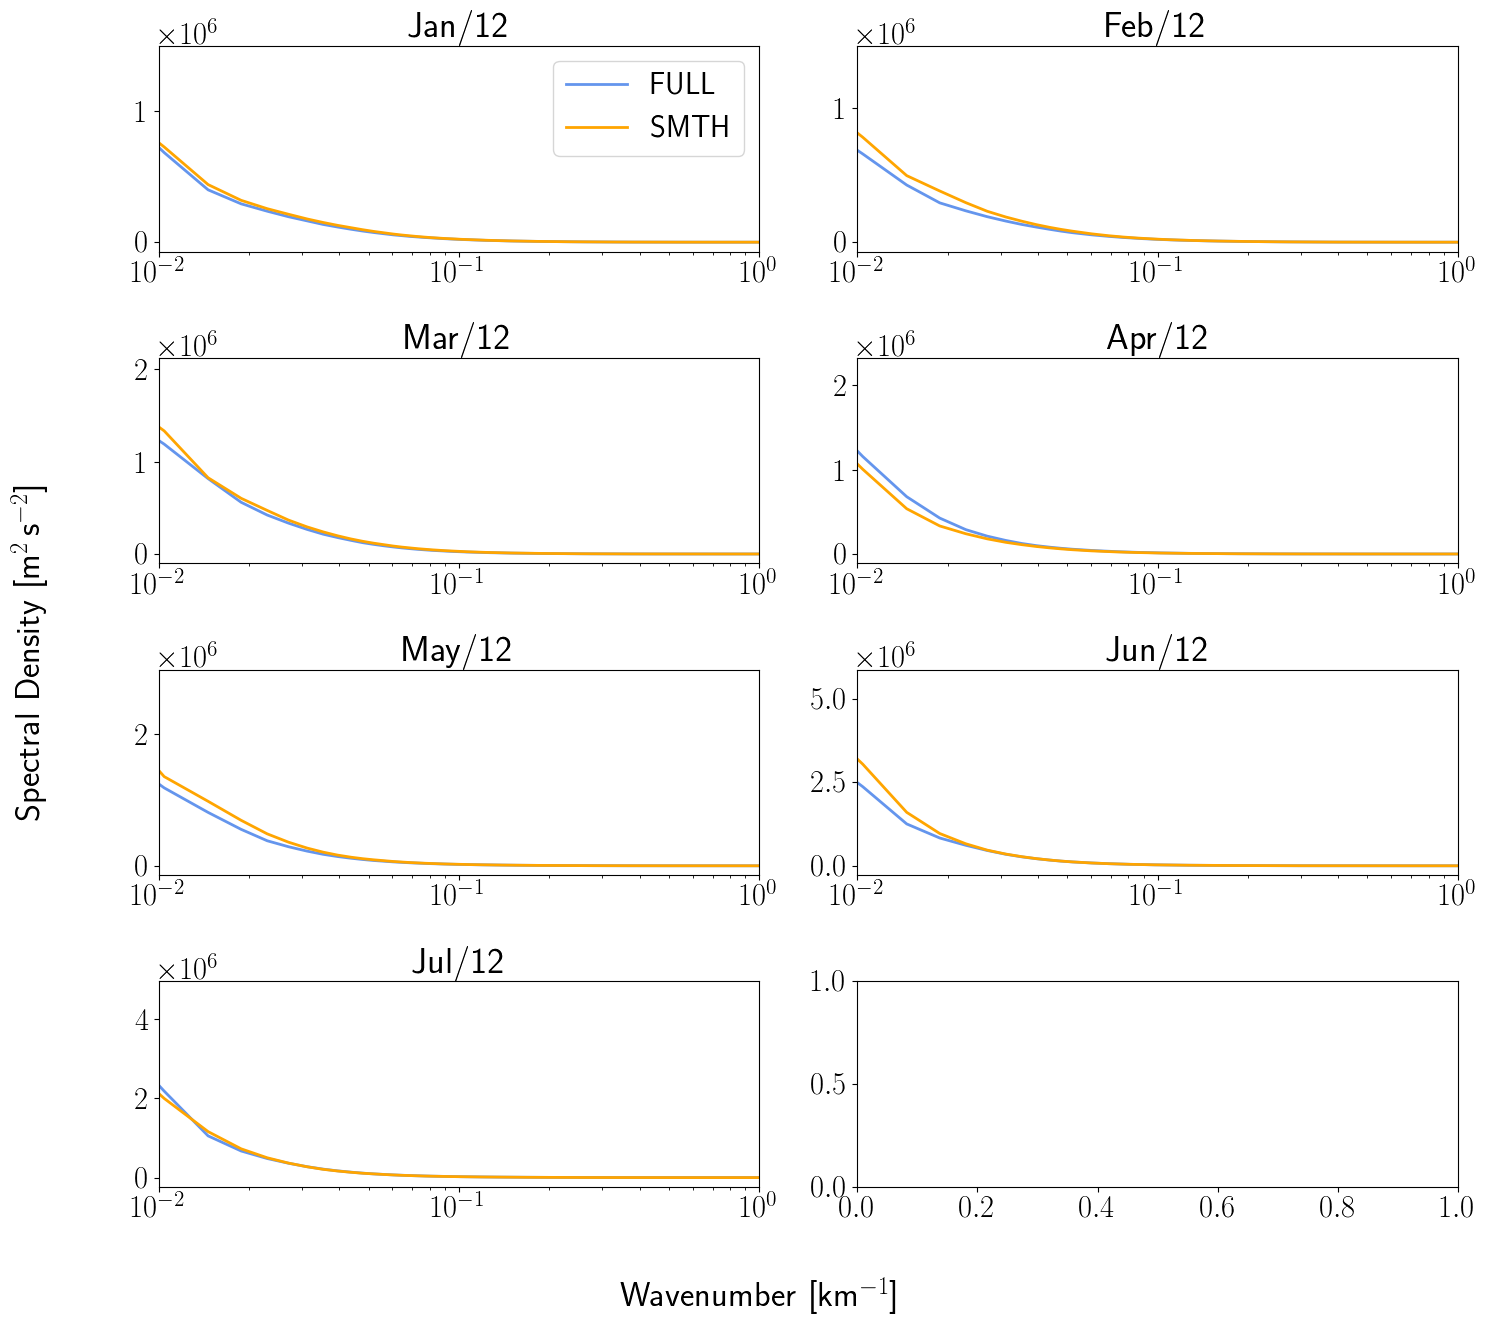

In [65]:




fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    KAf=ogive(Ekef.freq_r/dxx*1e3,(np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0))/dxx*1e3) #in metersss
    Kx=Ekef.freq_r/dxx #in Kilometers
    KAt=ogive(Eket.freq_r/dxx*1e3,(np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0))/dxx*1e3)#in metersss

    axs[ipp].plot(Kx,KAf,label='FULL',linewidth=2,color='cornflowerblue')
    axs[ipp].plot(Kx,KAt,label='SMTH',linewidth=2,color='orange')
    axs[ipp].set_xscale('log')
    # axs[ipp].set_yscale('log')

    # plt.title('KE',fontweight='bold')


    axs[ipp].set_xlim(1e-2,1)
    axs[ipp].set_title(mes_str[ipp])
    # if ipp in [0,2,4,6]:
    #     axs[ipp].set_ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')
    # if ipp in [6,7]:
    #     axs[ipp].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
    axs[0].legend()
    fig.supylabel(r'Spectral Density [m$^2\,$s$^{-2}$]',fontsize=25,x=0)
    fig.supxlabel(r'Wavenumber  [km$^{-1}$]',fontsize=25)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/TWOREG_monthly_ogive_KE.png')

